# **Deep Learning Methods with Pre-Trained Word Embeddings**

### **Important Installations**

In [ ]:
!pip install --upgrade gensim
!pip install xgboost
!pip install snowballstemmer
!pip install sentencepiece
!pip install pyspelling

     |████████████████████████████████| 23.9MB 1.5MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 1.2MB 12.1MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 40kB 5.8MB/s 


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Tokenization
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py    

### **Important imports**

In [ ]:
import pandas as pd
import numpy as np
import os

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import tokenization
from wordcloud import STOPWORDS

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string
import tensorflow as tf
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam


import logging
from numpy import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
df_main = pd.read_csv('/content/drive/MyDrive/WSU/Winter 2021/CSC 7810/Final Project/df_main.csv')
df_main['review'] = df_main['review'].values.astype('U')

##

### Create custom embedding for the data

In [ ]:
# The maximum number of words to be used. (most frequent)
VOCAB_SIZE = 35000 # vocabulary_size = 35000
# Max number of words in each review
MAX_SEQUENCE_LENGTH = 128
# Fixed dimensions (standard is 100)
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(df_main['review'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 37000 unique tokens.


### **Tokenize the Dataset**

In [ ]:
# Change to sequences
#import tokenizer
X = tokenizer.texts_to_sequences(df_main['review'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

Y = df_main['target']
print('Shape of data tensor:', X.shape)


Shape of data tensor: (114906, 128)


### **Split the data into training/testing**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(103415, 128) (103415,)
(11491, 128) (11491,)


## **Bi-Directional LSTM: No Embeddings**

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMBEDDING_DIM)),
    tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu'),

    # Using a sigmoid function since this is a binary classification problem
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         3500000   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 3,681,001
Trainable params: 3,681,001
Non-trainable params: 0
_________________________________________________________________


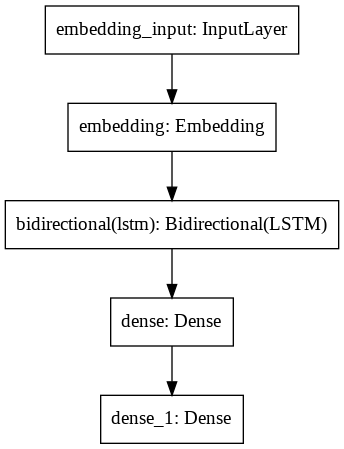

In [ ]:
tf.keras.utils.plot_model(model)


In [ ]:
## Fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 20
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
1293/1293 [==============================] - 64s 34ms/step - loss: 0.4282 - accuracy: 0.7946 - val_loss: 0.2570 - val_accuracy: 0.8985
Epoch 2/20
1293/1293 [==============================] - 42s 32ms/step - loss: 0.1940 - accuracy: 0.9279 - val_loss: 0.2369 - val_accuracy: 0.9107
Epoch 3/20
1293/1293 [==============================] - 42s 33ms/step - loss: 0.1287 - accuracy: 0.9533 - val_loss: 0.2357 - val_accuracy: 0.9148
Epoch 4/20
1293/1293 [==============================] - 50s 38ms/step - loss: 0.0882 - accuracy: 0.9681 - val_loss: 0.2391 - val_accuracy: 0.9214
Epoch 5/20
1293/1293 [==============================] - 66s 51ms/step - loss: 0.0664 - accuracy: 0.9760 - val_loss: 0.2634 - val_accuracy: 0.9225
Epoch 6/20
1293/1293 [==============================] - 66s 51ms/step - loss: 0.0480 - accuracy: 0.9837 - val_loss: 0.2979 - val_accuracy: 0.9282


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

360/360 [==============================] - 2s 6ms/step - loss: 0.2963 - accuracy: 0.9291
Test set
  Loss: 0.296
  Accuracy: 0.929


In [ ]:
from sklearn.metrics import classification_report
Y_pred = model.predict(X_test)
Y_predc = model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print('accuracy %s' % accuracy_score(Y_predc, Y_test))
print(classification_report(Y_test, Y_predc))

accuracy 0.929074928204682
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      4683
           1       0.94      0.94      0.94      6808

    accuracy                           0.93     11491
   macro avg       0.93      0.93      0.93     11491
weighted avg       0.93      0.93      0.93     11491



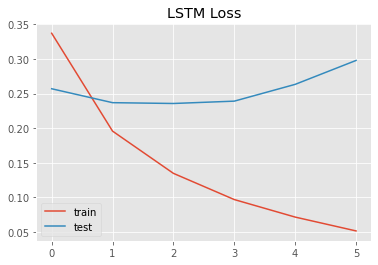

In [ ]:
plt.title('LSTM Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

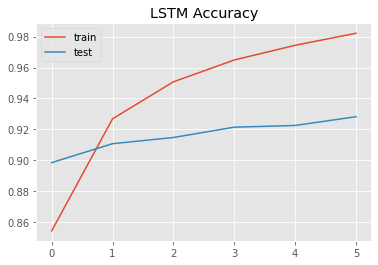

In [ ]:
plt.title('LSTM Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## **CNN-LSTM: No Embeddings**

In [ ]:
#model_lstm = tf.keras.Sequential([
    #tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM),
    #tf.keras.layers.SpatialDropout1D(0.2),
    #tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    #tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu'),
    #tf.keras.layers.Dense(1, activation='sigmoid')
#])
#model_lstm.summary()

In [ ]:
# LSTM-CNN Model
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(VOCAB_SIZE, 100, input_length=128))
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(64, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(LSTM(100))
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
    return model_conv
model_conv = create_conv_model()
epochs = 20
batch_size = 64
history = model_conv.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/20
1293/1293 [==============================] - 32s 23ms/step - loss: 0.4395 - accuracy: 0.7862 - val_loss: 0.2583 - val_accuracy: 0.8974
Epoch 2/20
1293/1293 [==============================] - 29s 22ms/step - loss: 0.1901 - accuracy: 0.9303 - val_loss: 0.2521 - val_accuracy: 0.9174
Epoch 3/20
1293/1293 [==============================] - 29s 22ms/step - loss: 0.0952 - accuracy: 0.9687 - val_loss: 0.2497 - val_accuracy: 0.9267
Epoch 4/20
1293/1293 [==============================] - 29s 22ms/step - loss: 0.0619 - accuracy: 0.9801 - val_loss: 0.2493 - val_accuracy: 0.9212
Epoch 5/20
1293/1293 [==============================] - 29s 22ms/step - loss: 0.0432 - accuracy: 0.9864 - val_loss: 0.2477 - val_accuracy: 0.9315
Epoch 6/20
1293/1293 [==============================] - 29s 22ms/step - loss: 0.0363 - accuracy: 0.9893 - val_loss: 0.2937 - val_accuracy: 0.9307
Epoch 7/20
1293/1293 [==============================] - 29s 22ms/step - loss: 0.0304 - accuracy: 0.9908 - val_loss: 0.3130 -

In [ ]:
accr = model_conv.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

360/360 [==============================] - 1s 3ms/step - loss: 0.2905 - accuracy: 0.9319
Test set
  Loss: 0.291
  Accuracy: 0.932


In [ ]:
from sklearn.metrics import classification_report
Y_pred = model_conv.predict(X_test)
Y_predc = model_conv.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print('accuracy %s' % accuracy_score(Y_predc, Y_test))
print(classification_report(Y_test, Y_predc))

accuracy 0.9318597162997129
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      4683
           1       0.93      0.95      0.94      6808

    accuracy                           0.93     11491
   macro avg       0.93      0.93      0.93     11491
weighted avg       0.93      0.93      0.93     11491



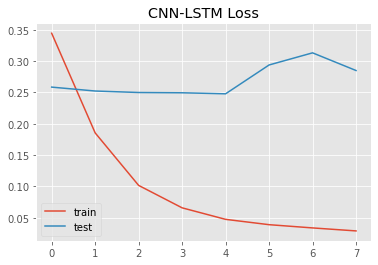

In [ ]:
plt.title('CNN-LSTM Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

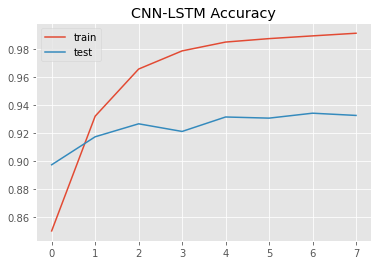

In [ ]:
plt.title('CNN-LSTM Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# **Pre-trained Embeddings**

## **GloVe 6B-100d**

In [ ]:
# Import GloVE. In this case, we're using 100D 
import re
from tqdm import tqdm_notebook
import pickle
from nltk.corpus import stopwords

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

VOCAB_SIZE = 37000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 128 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "/content/drive/MyDrive/WSU/Winter 2021/CSC 7810/Final Project/glove.6B.100d.txt"
#glove_embeddings = np.load('/content/drive/My Drive/WSU/Semester 2/IE 7860/Final Project/glove.840B.300d.pkl', allow_pickle=True)


In [ ]:
# Change to sequences
#import tokenizer
X = tokenizer.texts_to_sequences(df_main['review'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

Y = df_main['target']
print('Shape of data tensor:', X.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Shape of data tensor: (114906, 128)
(103415, 128) (103415,)
(11491, 128) (11491,)


In [ ]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(df_main['review'].values)
sequences = tokenizer.texts_to_sequences(df_main['review'].values)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 37000


In [ ]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (114906, 128)
Shape of label tensor: (114906,)


In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = Y[indices]

In [ ]:
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index), EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: /content/drive/MyDrive/WSU/Winter 2021/CSC 7810/Final Project/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


## **Bi-Directional LSTM: GloVE**

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 100, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMBEDDING_DIM)),
    tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu'),

    # Using a sigmoid function since this is a binary classification problem
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 128, 100)          3700000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 3,881,001
Trainable params: 181,001
Non-trainable params: 3,700,000
_________________________________________________________________


In [ ]:
## Fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 20
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
1293/1293 [==============================] - 26s 18ms/step - loss: 0.5204 - accuracy: 0.7329 - val_loss: 0.3547 - val_accuracy: 0.8432
Epoch 2/20
1293/1293 [==============================] - 23s 18ms/step - loss: 0.3433 - accuracy: 0.8500 - val_loss: 0.3099 - val_accuracy: 0.8690
Epoch 3/20
1293/1293 [==============================] - 23s 18ms/step - loss: 0.2829 - accuracy: 0.8806 - val_loss: 0.2842 - val_accuracy: 0.8817
Epoch 4/20
1293/1293 [==============================] - 23s 18ms/step - loss: 0.2426 - accuracy: 0.9007 - val_loss: 0.2655 - val_accuracy: 0.8930
Epoch 5/20
1293/1293 [==============================] - 23s 18ms/step - loss: 0.2043 - accuracy: 0.9188 - val_loss: 0.2591 - val_accuracy: 0.8977
Epoch 6/20
1293/1293 [==============================] - 23s 18ms/step - loss: 0.1678 - accuracy: 0.9361 - val_loss: 0.2685 - val_accuracy: 0.8990
Epoch 7/20
1293/1293 [==============================] - 23s 18ms/step - loss: 0.1369 - accuracy: 0.9479 - val_loss: 0.2557 -

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

360/360 [==============================] - 2s 6ms/step - loss: 0.3198 - accuracy: 0.9252
Test set
  Loss: 0.320
  Accuracy: 0.925


In [ ]:
from sklearn.metrics import classification_report
Y_pred = model.predict(X_test)
Y_predc = model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
print('accuracy %s' % accuracy_score(Y_predc, Y_test))
print('ROC AUC %s' % roc_auc_score(Y_test, Y_predc))
print(classification_report(Y_test, Y_predc))

accuracy 0.9252458445740145
ROC AUC 0.9181165034767101
              precision    recall  f1-score   support

           0       0.93      0.88      0.91      4683
           1       0.92      0.96      0.94      6808

    accuracy                           0.93     11491
   macro avg       0.93      0.92      0.92     11491
weighted avg       0.93      0.93      0.92     11491



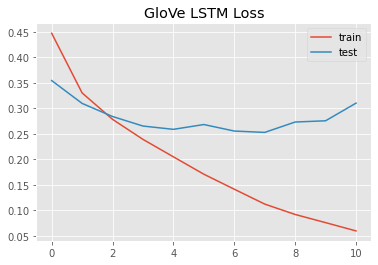

In [ ]:
plt.title('GloVe LSTM Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

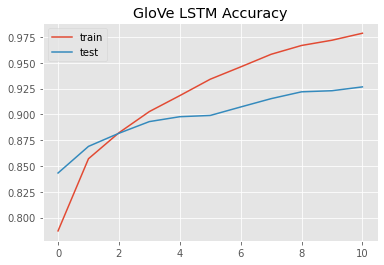

In [ ]:
plt.title('GloVe LSTM Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

### **CNN LSTM - Glove**

In [ ]:
import tensorflow as tf

# LSTM-CNN Model with GloVe


def create_convembedding_model():
    model_conv = tf.keras.Sequential()
    model_conv.add(Embedding(VOCAB_SIZE, 100, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False))
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(64, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(LSTM(100))
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
    return model_conv
model_conv = create_convembedding_model()
epochs = 20
batch_size = 64
history = model_conv.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])



Epoch 1/20
1293/1293 [==============================] - 9s 6ms/step - loss: 0.6055 - accuracy: 0.6581 - val_loss: 0.3908 - val_accuracy: 0.8250
Epoch 2/20
1293/1293 [==============================] - 7s 5ms/step - loss: 0.4061 - accuracy: 0.8169 - val_loss: 0.3475 - val_accuracy: 0.8452
Epoch 3/20
1293/1293 [==============================] - 7s 5ms/step - loss: 0.3467 - accuracy: 0.8487 - val_loss: 0.3192 - val_accuracy: 0.8614
Epoch 4/20
1293/1293 [==============================] - 7s 5ms/step - loss: 0.3115 - accuracy: 0.8642 - val_loss: 0.3076 - val_accuracy: 0.8668
Epoch 5/20
1293/1293 [==============================] - 7s 5ms/step - loss: 0.2879 - accuracy: 0.8775 - val_loss: 0.3032 - val_accuracy: 0.8742
Epoch 6/20
1293/1293 [==============================] - 7s 5ms/step - loss: 0.2771 - accuracy: 0.8819 - val_loss: 0.2955 - val_accuracy: 0.8779
Epoch 7/20
1293/1293 [==============================] - 7s 5ms/step - loss: 0.2585 - accuracy: 0.8911 - val_loss: 0.3000 - val_accuracy:

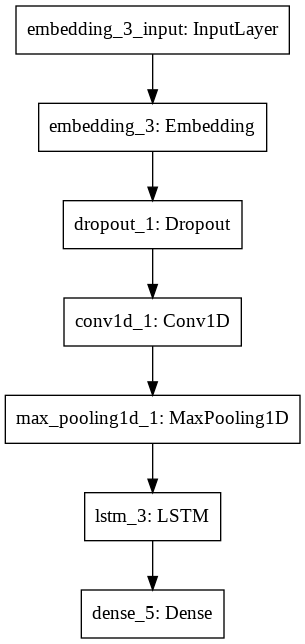

In [ ]:
tf.keras.utils.plot_model(model_conv)


In [ ]:
accr = model_conv.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

360/360 [==============================] - 1s 3ms/step - loss: 0.2626 - accuracy: 0.9025
Test set
  Loss: 0.263
  Accuracy: 0.903


In [ ]:
from sklearn.metrics import classification_report
Y_pred = model_conv.predict(X_test)
Y_predc = model_conv.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print('accuracy %s' % accuracy_score(Y_predc, Y_test))
print(classification_report(Y_test, Y_predc))

accuracy 0.9025324166739187
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4683
           1       0.92      0.92      0.92      6808

    accuracy                           0.90     11491
   macro avg       0.90      0.90      0.90     11491
weighted avg       0.90      0.90      0.90     11491



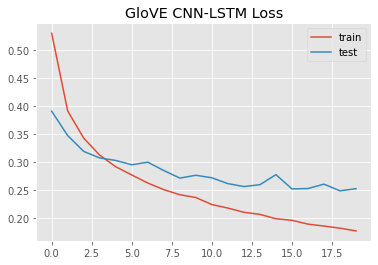

In [ ]:
plt.title('GloVE CNN-LSTM Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

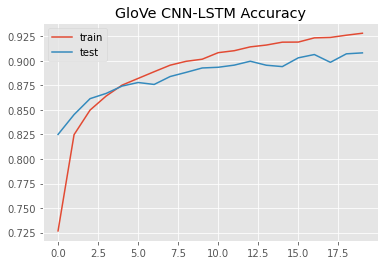

In [ ]:
plt.title('GloVe CNN-LSTM Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## **FastText 1M-300d**

In [ ]:
# Import GloVE. In this case, we're using 100D 
import re
from tqdm import tqdm_notebook
import pickle
from nltk.corpus import stopwords

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

MAX_NB_WORDS = 35000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 64 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 300      # embedding dimensions for word vectors (word2vec/GloVe)
FASTTEXT = "/content/drive/MyDrive/WSU/Winter 2021/CSC 7810/Final Project/wiki-news-300d-1M.vec"
#glove_embeddings = np.load('/content/drive/My Drive/WSU/Semester 2/IE 7860/Final Project/glove.840B.300d.pkl', allow_pickle=True)



In [ ]:
# Change to sequences
#import tokenizer
X = tokenizer.texts_to_sequences(df_main['review'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

Y = df_main['target']
print('Shape of data tensor:', X.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.70, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Shape of data tensor: (114906, 64)
(34471, 64) (34471,)
(80435, 64) (80435,)


In [ ]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(df_main['review'].values)
sequences = tokenizer.texts_to_sequences(df_main['review'].values)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 37000


In [ ]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (114906, 64)
Shape of label tensor: (114906,)


In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = Y[indices]

In [ ]:

embeddings_index = {}
f = open(FASTTEXT)
print('Loading Fastext from:', FASTTEXT,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index), EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading Fastext from: /content/drive/MyDrive/WSU/Winter 2021/CSC 7810/Final Project/wiki-news-300d-1M.vec ...Done.
 Proceeding with Embedding Matrix... Completed!


### **LSTM- Fasttext**

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 300, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMBEDDING_DIM)),
    tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu'),

    # Using a sigmoid function since this is a binary classification problem
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 64, 300)           11100000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dense_6 (Dense)              (None, 300)               180300    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 301       
Total params: 12,723,001
Trainable params: 1,623,001
Non-trainable params: 11,100,000
_________________________________________________________________


In [ ]:
## Fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 20
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
431/431 [==============================] - 12s 22ms/step - loss: 0.6090 - accuracy: 0.6668 - val_loss: 0.4242 - val_accuracy: 0.8123
Epoch 2/20
431/431 [==============================] - 9s 21ms/step - loss: 0.3998 - accuracy: 0.8247 - val_loss: 0.4077 - val_accuracy: 0.8117
Epoch 3/20
431/431 [==============================] - 9s 21ms/step - loss: 0.3515 - accuracy: 0.8489 - val_loss: 0.3456 - val_accuracy: 0.8508
Epoch 4/20
431/431 [==============================] - 9s 21ms/step - loss: 0.2965 - accuracy: 0.8747 - val_loss: 0.3311 - val_accuracy: 0.8657
Epoch 5/20
431/431 [==============================] - 9s 21ms/step - loss: 0.2534 - accuracy: 0.8960 - val_loss: 0.3590 - val_accuracy: 0.8473
Epoch 6/20
431/431 [==============================] - 9s 21ms/step - loss: 0.2046 - accuracy: 0.9189 - val_loss: 0.3413 - val_accuracy: 0.8669
Epoch 7/20
431/431 [==============================] - 9s 21ms/step - loss: 0.1601 - accuracy: 0.9373 - val_loss: 0.3919 - val_accuracy: 0.869

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2514/2514 [==============================] - 16s 6ms/step - loss: 0.3891 - accuracy: 0.8661
Test set
  Loss: 0.389
  Accuracy: 0.866


In [ ]:
from sklearn.metrics import classification_report
Y_pred = model.predict(X_test)
Y_predc = model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
print('accuracy %s' % accuracy_score(Y_predc, Y_test))
print('ROC AUC %s' % roc_auc_score(Y_test, Y_predc))
print(classification_report(Y_test, Y_predc))

accuracy 0.866140361782806
ROC AUC 0.8515897307912067
              precision    recall  f1-score   support

           0       0.89      0.77      0.82     32856
           1       0.86      0.93      0.89     47579

    accuracy                           0.87     80435
   macro avg       0.87      0.85      0.86     80435
weighted avg       0.87      0.87      0.86     80435



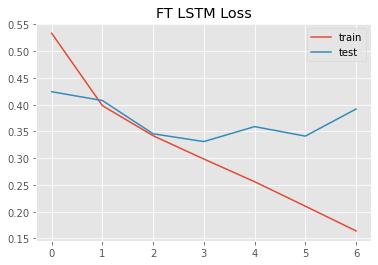

In [ ]:
plt.title('FT LSTM Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

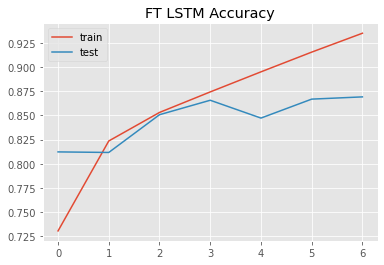

In [ ]:
plt.title('FT LSTM Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

### **CNN- Fasttext**

In [ ]:
import tensorflow as tf

# LSTM-CNN Model with GloVe


def create_convembedding_model():
    model_conv = tf.keras.Sequential()
    model_conv.add(Embedding(VOCAB_SIZE, 300, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False))
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(64, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(LSTM(100))
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
    return model_conv
model_conv = create_convembedding_model()
epochs = 20
batch_size = 64
history = model_conv.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])



Epoch 1/20
431/431 [==============================] - 4s 6ms/step - loss: 0.6334 - accuracy: 0.6278 - val_loss: 0.4371 - val_accuracy: 0.8084
Epoch 2/20
431/431 [==============================] - 2s 5ms/step - loss: 0.4326 - accuracy: 0.8002 - val_loss: 0.3908 - val_accuracy: 0.8231
Epoch 3/20
431/431 [==============================] - 2s 5ms/step - loss: 0.3649 - accuracy: 0.8391 - val_loss: 0.3620 - val_accuracy: 0.8394
Epoch 4/20
431/431 [==============================] - 2s 5ms/step - loss: 0.3003 - accuracy: 0.8705 - val_loss: 0.3498 - val_accuracy: 0.8557
Epoch 5/20
431/431 [==============================] - 2s 5ms/step - loss: 0.2629 - accuracy: 0.8902 - val_loss: 0.3759 - val_accuracy: 0.8432
Epoch 6/20
431/431 [==============================] - 2s 5ms/step - loss: 0.2230 - accuracy: 0.9073 - val_loss: 0.3616 - val_accuracy: 0.8582
Epoch 7/20
431/431 [==============================] - 2s 5ms/step - loss: 0.1925 - accuracy: 0.9200 - val_loss: 0.3607 - val_accuracy: 0.8628


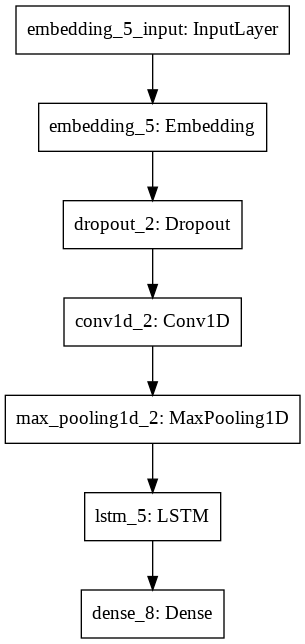

In [ ]:
tf.keras.utils.plot_model(model_conv)

In [ ]:
accr = model_conv.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2514/2514 [==============================] - 7s 3ms/step - loss: 0.3651 - accuracy: 0.8561
Test set
  Loss: 0.365
  Accuracy: 0.856


In [ ]:
from sklearn.metrics import classification_report
Y_pred = model_conv.predict(X_test)
Y_predc = model_conv.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
print('accuracy %s' % accuracy_score(Y_predc, Y_test))
print('ROC AUC %s' % roc_auc_score(Y_test, Y_predc))
print(classification_report(Y_test, Y_predc))

accuracy 0.8561447131223969
ROC AUC 0.8525164087303485
              precision    recall  f1-score   support

           0       0.82      0.83      0.83     32856
           1       0.88      0.87      0.88     47579

    accuracy                           0.86     80435
   macro avg       0.85      0.85      0.85     80435
weighted avg       0.86      0.86      0.86     80435



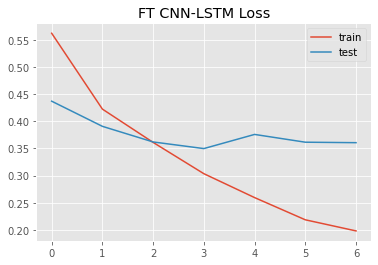

In [ ]:
plt.title('FT CNN-LSTM Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

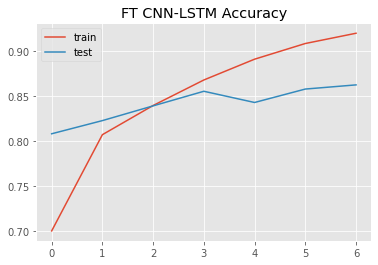

In [ ]:
plt.title('FT CNN-LSTM Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();